In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from collections import Counter

In [2]:
# Read CSV
df = pd.read_csv('../data/cs-training.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
# Clean column names
cleanCol = []
for i in range(len(df.columns)):
    cleanCol.append(df.columns[i].replace('-', 'to'))
    
df.columns = cleanCol

for col in cleanCol:
    print(col)

SeriousDlqin2yrs
RevolvingUtilizationOfUnsecuredLines
age
NumberOfTime30to59DaysPastDueNotWorse
DebtRatio
MonthlyIncome
NumberOfOpenCreditLinesAndLoans
NumberOfTimes90DaysLate
NumberRealEstateLoansOrLines
NumberOfTime60to89DaysPastDueNotWorse
NumberOfDependents


In [4]:
# Calculate std dev values
def findStd(series,num):
    mean = series.mean()
    stdDev = series.std()
    std_pos = mean + num*stdDev
    std_neg = mean - num*stdDev
    
    stdValues = {
        'std+': std_pos,
        'std-': std_neg
    }
    
    return stdValues

In [5]:
def standardizeValues(dfColumn,stdRet,columnName,classifier='mean',compareColumn='N/A',lookupTable='N/A'):
    if classifier == 'lookup':
        df.loc[dfColumn.isnull(),columnName] = compareColumn.map(lookupTable)
        df.loc[dfColumn>stdRet['std+'],columnName] = compareColumn.map(lookupTable)
        df.loc[dfColumn<stdRet['std-'],columnName] = compareColumn.map(lookupTable)
    elif classifier == 'median':
        df.loc[dfColumn.isnull(),columnName] = dfColumn.median()
        df.loc[dfColumn>stdRet['std+'],columnName] = dfColumn.median()
        df.loc[dfColumn<stdRet['std-'],columnName] = dfColumn.median()
    else:
        df.loc[dfColumn.isnull(),columnName] = dfColumn.mean()
        df.loc[dfColumn>stdRet['std+'],columnName] = dfColumn.mean()
        df.loc[dfColumn<stdRet['std-'],columnName] = dfColumn.mean()

In [6]:
def standardizePlaceholders(dfColumn,columnName,classifier='mean'):
    if classifier == 'median':
        df.loc[dfColumn==98,columnName] = dfColumn.median()
        df.loc[dfColumn==96,columnName] = dfColumn.median()
        
    else:
        df.loc[dfColumn==98,columnName] = dfColumn.mean()
        df.loc[dfColumn==98,columnName] = dfColumn.mean()

## Clean Age

### Remove common undefined entry codes

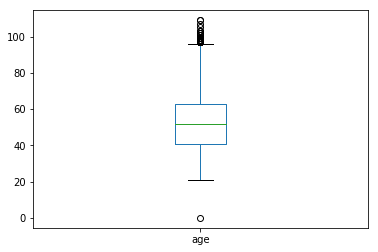

In [7]:
df.age.plot.box()

In [8]:
# Get std deviation and replace outliers
ageStd = findStd(df.age,3)
standardizeValues(df.age,ageStd,'age')
df.age = df.age.astype(int)

In [9]:
# Counter(df.age)
df.age.max()

96

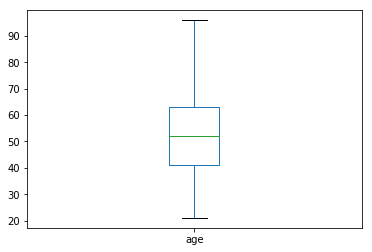

In [10]:
df.age.plot.box()

## Clean Salary

### Remove NaN's

In [11]:
# Drop NAN from OG DF
df_MI = df[['age','MonthlyIncome']]

In [12]:
df_MIsansNAN = df_MI.dropna(axis=0, how='any')

# Remove Income Outliers outside of 3 STD
df_MIsansNAN_std = df_MIsansNAN[np.abs(df_MIsansNAN.MonthlyIncome-df_MIsansNAN.MonthlyIncome.mean())<=(3*df_MIsansNAN.MonthlyIncome.std())]

df_MIsansNAN_std.head()

,age,MonthlyIncome
0,45,9120.0
1,40,2600.0
2,38,3042.0
3,30,3300.0
5,74,3500.0


### Create lookup table for Salary Avg by Age

In [13]:
# Create lookup table for mean per age
ageSalaryLookup = pd.DataFrame(df_MIsansNAN_std.groupby(['age']).MonthlyIncome.mean())
ageSalaryLookup.head()

,MonthlyIncome
age,
21,1128.123077
22,1312.592705
23,1728.003883
24,2061.717791
25,2529.139272


In [14]:
# Find all values 3x std
incomeStd = findStd(df_MIsansNAN_std.MonthlyIncome,3)
standardizeValues(df.MonthlyIncome,incomeStd,'MonthlyIncome','lookup',df.age,ageSalaryLookup.MonthlyIncome)

In [15]:
# Check for Null values
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

NumberOfDependents    3924
dtype: int64

In [16]:
df.MonthlyIncome.describe()

count    150000.000000
mean       6114.110913
std        3336.776302
min           0.000000
25%        3800.000000
50%        5900.000000
75%        7405.250000
max       20087.000000
Name: MonthlyIncome, dtype: float64

## Clean RevolvingUtilizationOfUnsecuredLines

In [17]:
df.RevolvingUtilizationOfUnsecuredLines.describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [18]:
# Define deviation and replace outliers
revLnStd = {'std+': 2, 'std-': 0}
standardizeValues(df.RevolvingUtilizationOfUnsecuredLines,revLnStd,'RevolvingUtilizationOfUnsecuredLines','median')

In [19]:
df.RevolvingUtilizationOfUnsecuredLines.describe()

count    150000.000000
mean          0.319924
std           0.355123
min           0.000000
25%           0.029867
50%           0.154178
75%           0.552810
max           1.998676
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

## Clean NumberOfTime30to59DaysPastDueNotWorse

In [20]:
df.NumberOfTime30to59DaysPastDueNotWorse.describe()

count    150000.000000
mean          0.421033
std           4.192781
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30to59DaysPastDueNotWorse, dtype: float64

In [21]:
Counter(df.NumberOfTime30to59DaysPastDueNotWorse)

Counter({0: 126018,
         1: 16033,
         2: 4598,
         3: 1754,
         4: 747,
         5: 342,
         6: 140,
         7: 54,
         8: 25,
         9: 12,
         10: 4,
         11: 1,
         12: 2,
         13: 1,
         96: 5,
         98: 264})

In [22]:
# Replace placeholders with the median
standardizePlaceholders(df.NumberOfTime30to59DaysPastDueNotWorse,'NumberOfTime30to59DaysPastDueNotWorse','median')

In [23]:
df.NumberOfTime30to59DaysPastDueNotWorse.describe()

count    150000.000000
mean          0.245353
std           0.697231
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: NumberOfTime30to59DaysPastDueNotWorse, dtype: float64

## Clean DebtRatio

In [24]:
df.DebtRatio.describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

In [25]:
df.DebtRatio.median()

0.366507841

In [26]:
debtRatioStd = {'std+': 2, 'std-': 0}
standardizeValues(df.DebtRatio,debtRatioStd,'DebtRatio','median')

In [27]:
df.DebtRatio.describe()

count    150000.000000
mean          0.344349
std           0.263902
min           0.000000
25%           0.175074
50%           0.366506
75%           0.405709
max           2.000000
Name: DebtRatio, dtype: float64

## Clean NumberOfOpenCreditLinesAndLoans

In [28]:
df.NumberOfOpenCreditLinesAndLoans.describe()

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [29]:
Counter(df.NumberOfOpenCreditLinesAndLoans)

Counter({0: 1888,
         1: 4438,
         2: 6666,
         3: 9058,
         4: 11609,
         5: 12931,
         6: 13614,
         7: 13245,
         8: 12562,
         9: 11355,
         10: 9624,
         11: 8321,
         12: 7005,
         13: 5667,
         14: 4546,
         15: 3645,
         16: 3000,
         17: 2370,
         18: 1874,
         19: 1433,
         20: 1169,
         21: 864,
         22: 685,
         23: 533,
         24: 422,
         25: 337,
         26: 239,
         27: 194,
         28: 150,
         29: 114,
         30: 88,
         31: 74,
         32: 52,
         33: 47,
         34: 35,
         35: 27,
         36: 18,
         37: 7,
         38: 13,
         39: 9,
         40: 10,
         41: 4,
         42: 8,
         43: 8,
         44: 2,
         45: 8,
         46: 3,
         47: 2,
         48: 6,
         49: 4,
         50: 2,
         51: 2,
         52: 3,
         53: 1,
         54: 4,
         56: 2,
         57: 2,
  

## NumberOfTimes90DaysLate

In [30]:
df.NumberOfTimes90DaysLate.describe()

count    150000.000000
mean          0.265973
std           4.169304
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTimes90DaysLate, dtype: float64

In [31]:
# Replace placeholders with the median
standardizePlaceholders(df.NumberOfTimes90DaysLate,'NumberOfTimes90DaysLate','median')
df.NumberOfTimes90DaysLate = df.NumberOfTimes90DaysLate.astype(int)

In [32]:
Counter(df.NumberOfTimes90DaysLate)

Counter({0: 141931,
         1: 5243,
         2: 1555,
         3: 667,
         4: 291,
         5: 131,
         6: 80,
         7: 38,
         8: 21,
         9: 19,
         10: 8,
         11: 5,
         12: 2,
         13: 4,
         14: 2,
         15: 2,
         17: 1})

## Clean NumberRealEstateLoansOrLines

In [33]:
df.NumberRealEstateLoansOrLines.describe()

count    150000.000000
mean          1.018240
std           1.129771
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

In [34]:
Counter(df.NumberRealEstateLoansOrLines)

Counter({0: 56188,
         1: 52338,
         2: 31522,
         3: 6300,
         4: 2170,
         5: 689,
         6: 320,
         7: 171,
         8: 93,
         9: 78,
         10: 37,
         11: 23,
         12: 18,
         13: 15,
         14: 7,
         15: 7,
         16: 4,
         17: 4,
         18: 2,
         19: 2,
         20: 2,
         21: 1,
         23: 2,
         25: 3,
         26: 1,
         29: 1,
         32: 1,
         54: 1})

## Clean NumberOfTime60to89DaysPastDueNotWorse

In [35]:
df.NumberOfTime60to89DaysPastDueNotWorse.describe()

count    150000.000000
mean          0.240387
std           4.155179
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime60to89DaysPastDueNotWorse, dtype: float64

In [36]:
# Replace placeholders with the median
standardizePlaceholders(df.NumberOfTime60to89DaysPastDueNotWorse,'NumberOfTime60to89DaysPastDueNotWorse','median')
df.NumberOfTime60to89DaysPastDueNotWorse = df.NumberOfTime60to89DaysPastDueNotWorse.astype(int)

In [37]:
Counter(df.NumberOfTime60to89DaysPastDueNotWorse)

Counter({0: 142665,
         1: 5731,
         2: 1118,
         3: 318,
         4: 105,
         5: 34,
         6: 16,
         7: 9,
         8: 2,
         9: 1,
         11: 1})

## Clean NumberOfDependents

In [38]:
df.NumberOfDependents.describe()

count    146076.000000
mean          0.757222
std           1.115086
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [39]:
# Drop NAN from OG DF
df_D = df[['NumberOfDependents']]
df_DsansNAN = df_D.dropna(axis=0, how='any')

Counter(df_DsansNAN.NumberOfDependents)

Counter({0.0: 86902,
         1.0: 26316,
         2.0: 19522,
         3.0: 9483,
         4.0: 2862,
         5.0: 746,
         6.0: 158,
         7.0: 51,
         8.0: 24,
         9.0: 5,
         10.0: 5,
         13.0: 1,
         20.0: 1})

In [40]:
# Define deviation and replace outliers
depStd = {'std+': df.NumberOfDependents.max(), 'std-': df.NumberOfDependents.min()}
standardizeValues(df.NumberOfDependents,depStd,'NumberOfDependents','median')


In [41]:
df.NumberOfDependents.describe()

count    150000.000000
mean          0.737413
std           1.107021
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

# Feature Engineering

https://github.com/IdoZehori/Credit_Score/blob/master/Credit%20score.ipynb

# MODEL IT

In [42]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']
print(X.shape, y.shape)

(150000, 10) (150000,)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [44]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
print(f"Training Data Score: {model.score(X_train, y_train)}")
print(f"Testing Data Score: {model.score(X_test, y_test)}")

Training Data Score: 0.9370844444444445
Testing Data Score: 0.9361333333333334


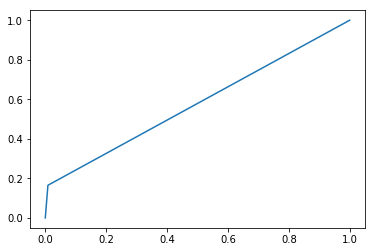

ValueError: bad input shape (37500, 2)

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.show()
AUC = roc_auc_score(y_test, predictions_proba)
AUC